<a href="https://colab.research.google.com/github/aliasgherman/trenddetection/blob/master/TrendDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta
import io

# Your constants here : Based on the KPI file being imported
#### WINDOW = Number of days to consider in the rolling average and standard deviation window to find if current day is a deviation
#### SIGMA_THRESHOLD = Any deviation above this threshold will be considered as a trend change
#### KEY = The fields in the file which are not the KPI but the device identifier. Like RNC Name, EnodeB Name, Cell Name etc. Case sensitive
#### TIMEINDEX = The field in the file which represents Time. Should be convertable into DateTime
#### DOI = Date of Interest. If you know that the changes would have happened around a specific date, then specify it as "YYYY-MM-DD", else keep this field as DOI = "" and the script will highlight all the trend changes it can see.

## ISGOOGLE = If you are using this script on Google Colab then keep it True, else False. Only difference is in loading file where on Google, you will need to upload a file whereas on Local computer, you need to specify the filename as a variable called file1

In [0]:
file1 = "C:\\Users\\Test\\Desktop\\KPI_Sample.csv" #only needed if you load this script on your local system. On google colab, you will be asked to upload a KPI file,

WINDOW = 7

SIGMA_THRESHOLD = 1.8

DOI = "2019-05-13" #Date of your interest (if you had any major activity which could possibly impact any KPI/Counter)

      #you can keep DOI = "" if you want to plot all significant changes in the KPIs.

KEY = ["Device", "Second_Key", "Third_Key"] #Example can be like RNC, NodeB, CellName

TIMEINDEX = "Timestamp"

ISGOOGLE = True #if using Google Colab, keep this True, else make it false to load KPI file from variable file1

# Upload your file here. It should be a CSV file

In [52]:
if ISGOOGLE == True:
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
    #print(uploaded)
    file1 = fn
    print(file1)

Saving Sample_KPIs.csv to Sample_KPIs (10).csv
User uploaded file "Sample_KPIs.csv" with length 41745 bytes
Sample_KPIs.csv


Loading the file and performing basic error checks

In [0]:
try:
  if ISGOOGLE == False:
    df = pd.read_csv(file1)
  else:
    
    df = pd.read_csv(io.StringIO(uploaded[file1].decode('utf-8')))
except Exception as e:
  print("An exception has occurred while trying to read the CSV. ", file1, ". Exception : ", e)
  assert False # Please fix the error printed and then re-run the notebook

if len([x for x in KEY if x not in df.columns.values]) > 0: #check if the user specified some KEYs which are not present in the data source
  print("Some KEYs specified in the KEY variable do not exist in the dataframe. ", [x for x in KEY if x not in df.columns.values])
  assert False # Please fix the error printed and then re-run the notebook

if TIMEINDEX not in df.columns.values: #check if the user specified some KEYs which are not present in the data source
  print("Variable specified as timeindex is not in the dataframe . ", TIMEINDEX)
  assert False # Please fix the error printed and then re-run the notebook

In [0]:
MYKEY = "AAM_KEY"

#Here we are just creating some dates before and after the Date of interest

if DOI != "":
  try:
    DOIE1 = date(int(DOI.split("-")[0]),int(DOI.split("-")[1]),int(DOI.split("-")[2])) - timedelta(days=1)
    DOIE2 = DOIE1 + timedelta(days=1)
    DOIE3 = DOIE1 + timedelta(days=2)
    DOIE4 = DOIE1 + timedelta(days=-2)
    DOIE5 = DOIE1 + timedelta(days=3)
    DOIE6 = DOIE1 + timedelta(days=-3)
  except Exception as e:
    print("While trying to convert DOI into date, an error ocurred. Please check DOI variable and try again. ", DOI, ". Exception ", e)
    assert False #Please fix the error reported and re-run the notebook

In [0]:
#Step 1 , convert the timeindex to a datetime value
df[TIMEINDEX] = pd.to_datetime(df[TIMEINDEX], errors='coerce')


In [0]:
#step 2
df[MYKEY] = ""
for i in KEY:
    df[MYKEY] = df[MYKEY] + "_" + df[i].astype(str)

In [0]:
#step 3, create a temp dataframe with KPIs only to check deviations and keey a backup of original frame as well

df_temp = df[ [x for x in df.columns if x not in KEY]] #keep df without the KEYS.
df2 = df.copy()

In [0]:
#step 4, Here we create columns for moving averages and moving standard deviations for each KPI

KPI_COLUMNS = [x for x in df.columns if x not in KEY and x != MYKEY and x != TIMEINDEX]

for i in KPI_COLUMNS:
    df[i] = pd.to_numeric(df[i], errors='coerce') #We consider everything else as a KPI in the file.
            #so everything should be numeric for comparison

res = pd.DataFrame()
for i in df_temp[MYKEY].unique():
    temp = df_temp[df_temp[MYKEY] == i].copy()
    for j in KPI_COLUMNS:
        currName = j
        temp["mean_" + currName] = temp[j].rolling(window=WINDOW, min_periods=1).mean()
        temp["std_" + currName] = temp[j].rolling(window=WINDOW, min_periods=1).std()
        temp["mydev_" + currName] = (temp[j] - temp["mean_" + currName]) / temp["std_" + currName]
    res = pd.concat([res, temp], sort=False)
        
res_backup = res.copy()

res = res.set_index(TIMEINDEX)

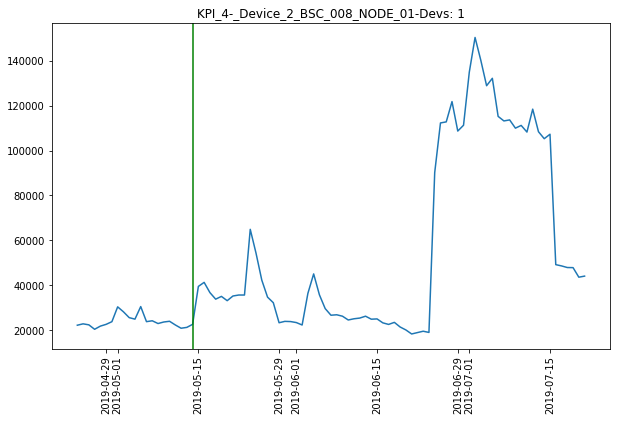

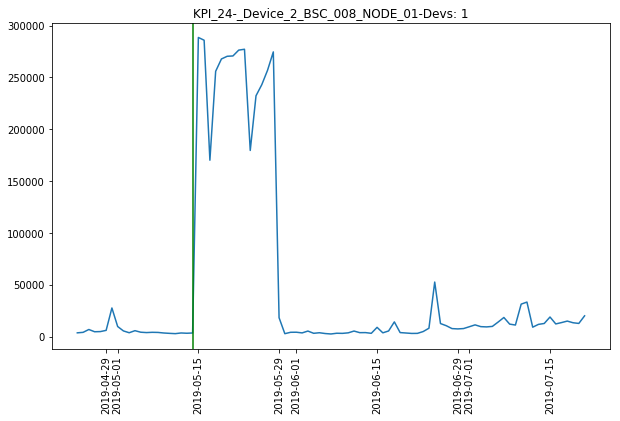

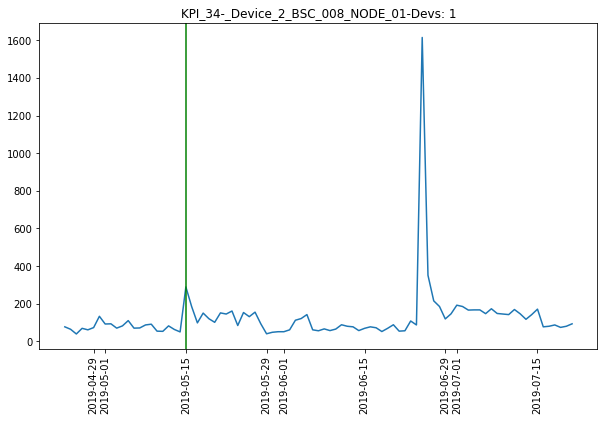

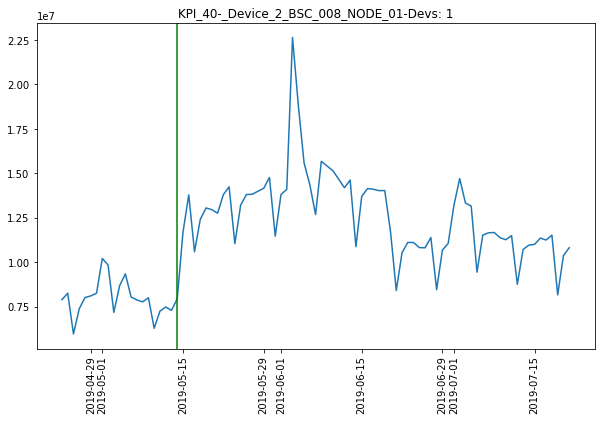

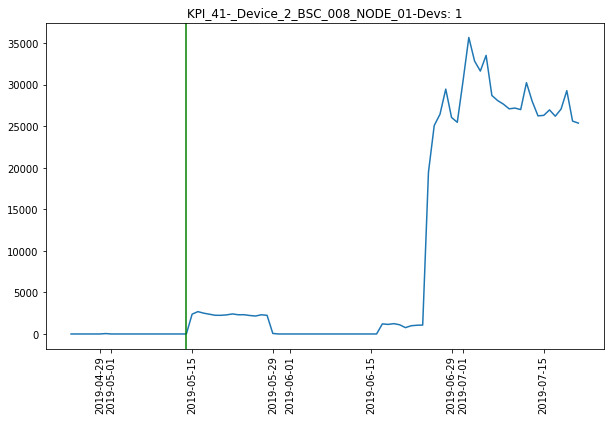

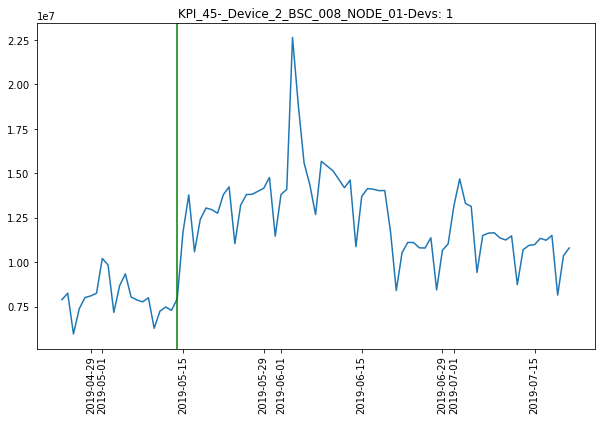

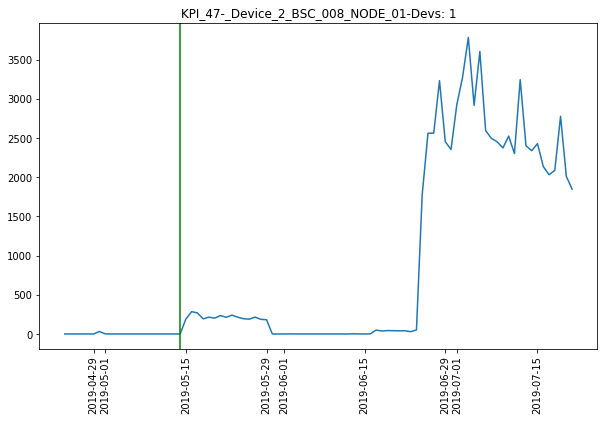

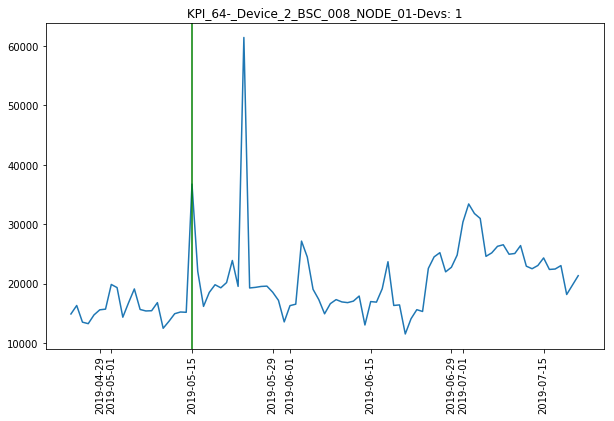

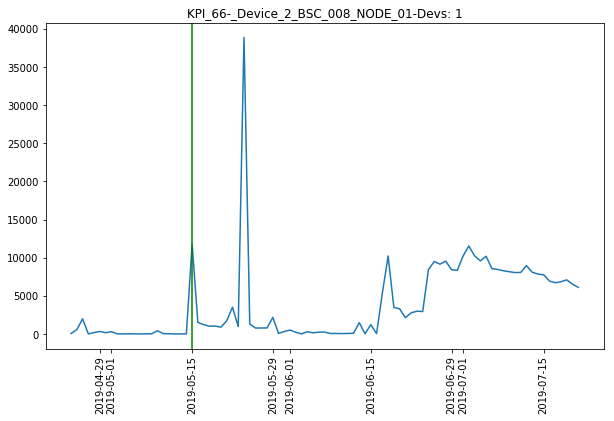

In [59]:
#step 5, here output ONLY THE KPIs which show deviations. If DOI was "", then all KPIs which any deviations will be shown here.

for DEV in res[MYKEY].unique():
    for k in KPI_COLUMNS:
        fig = plt.figure(figsize=(10,6))
        ax = plt.subplot(1,1,1)
        ax.plot(pd.Series(res[res[MYKEY] == DEV][k]))
        devCount = 0
        if DOI.strip() == "": #no date of interest specified.
            for i in res[(res[MYKEY] == DEV) & ((res["mydev_" + k] >= SIGMA_THRESHOLD) |
                         (res["mydev_" + k] <= -SIGMA_THRESHOLD))].index.values:
                devCount += 1
                ax.axvline(i, color='g')
        else:
            
            for i in res[((res[MYKEY] == DEV) & ((res["mydev_" + k] >= SIGMA_THRESHOLD) |
                         (res["mydev_" + k] <= -SIGMA_THRESHOLD))) & 
                         ((res.index == str(DOIE1)) | 
                         (res.index == str(DOIE2)) |
                         (res.index == str(DOIE3)) |
                         (res.index == str(DOIE4)) |
                         (res.index == str(DOIE5)) |
                         (res.index == str(DOIE6)))].index.values:
                devCount += 1
                ax.axvline(i, color='g')
                
        plt.xticks(rotation='vertical')
        plt.title(str(k) + "-" + str(DEV) + "-Devs: " + str(devCount))
        if devCount > 0:
            plt.show()
        else:
            plt.close()